# Cargue Librerías Modelo Random Forest

In [ ]:
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import OneHotEncoder
from sklearn.preprocessing   import StandardScaler
from sklearn.compose         import make_column_selector
from sklearn.preprocessing   import PolynomialFeatures 
from sklearn.model_selection import train_test_split
from scipy                   import stats
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns
import statsmodels.api       as sm
import statsmodels.formula.api as sfm
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import matplotlib.ticker as ticker
import multiprocessing
from sklearn.metrics import plot_roc_curve, auc
from sklearn.svm import SVC
from feature_engine import variable_transformers as vt

In [ ]:
icetex_predict = 'C:/Users/elkcuepa/Documents/Prejuridico/icetex_to_predict.xlsx'
icetex_predict = pd.read_excel(icetex_predict)

In [ ]:
sns.set(style='darkgrid', rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=0.9)

In [ ]:
icetex_predict_PCA = icetex_predict.drop(columns=['IES','NOMBREPROGRAMA','APELLIDOS','NOMBRES',
                                                     'FECHAENTRADA','FECHAACTUALIZACION','FECHAULTPAGO_y','FECHAMOVIMIENTO',
                                                  'FECHA_ACUERDO','FECHAENTRADA','AÑO_MES_ENTRADA', 'AÑO_MES_SALIDA',
                                                  'DIA_FREQ_ACUERDO', 'MES_FREQ_ACUERDO','año_FREQ_ACUERDO','FECHA_ACUERDO', 'ESTADO_ACUERDO',
                                                  'TIPO_ACUERDO','Dia_contactoEfectivo', 'Dia_contactoNOEfectivo',
                                                  'AÑO_MES_ENTRADA', 'AÑO_MES_SALIDA','VCTO_CUOTA1'], axis=1)

In [ ]:
icetex_predict_PCA.shape

(137816, 40)

# Análisis final de datos vs Tiempos de pago

## Nulos

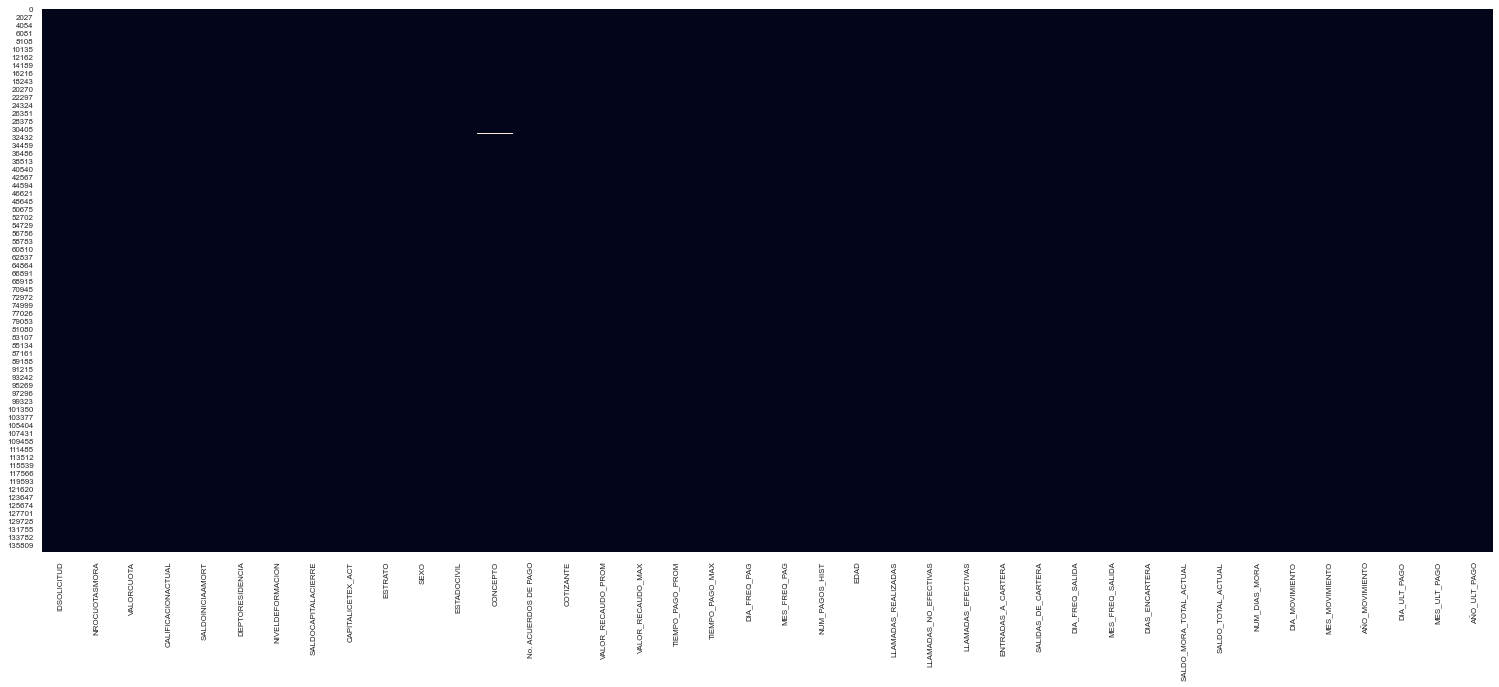

In [ ]:
plt.figure(figsize=(26, 10))
sns.heatmap(icetex_predict_PCA.isnull(), cbar=False)

## Análisis outliers

In [ ]:
Q1 = icetex_predict_PCA.quantile(0.25)
Q3 = icetex_predict_PCA.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

IDSOLICITUD                1.202840e+06
NROCUOTASMORA              2.000000e+00
VALORCUOTA                 2.163672e+05
SALDOINICIAAMORT           1.367412e+07
SALDOCAPITALACIERRE        1.316823e+07
CAPITALICETEX_ACT          1.323364e+07
ESTRATO                    2.000000e+00
No. ACUERDOS DE PAGO       2.000000e+00
VALOR_RECAUDO_PROM         2.742922e+05
VALOR_RECAUDO_MAX          8.191008e+05
TIEMPO_PAGO_PROM           5.225325e+01
TIEMPO_PAGO_MAX            1.480000e+02
DIA_FREQ_PAG               1.200000e+01
MES_FREQ_PAG               7.000000e+00
NUM_PAGOS_HIST             1.600000e+00
EDAD                       7.000000e+00
LLAMADAS_REALIZADAS        8.000000e+00
LLAMADAS_NO_EFECTIVAS      4.000000e+00
LLAMADAS_EFECTIVAS         4.000000e+00
ENTRADAS_A_CARTERA         3.000000e+00
SALIDAS_DE_CARTERA         3.000000e+00
DIA_FREQ_SALIDA            2.300000e+01
MES_FREQ_SALIDA            6.000000e+00
DIAS_ENCARTERA             3.700000e+01
SALDO_MORA_TOTAL_ACTUAL    1.476860e+06


In [ ]:
icetex_predict_out = icetex_predict_PCA[(np.abs(stats.zscore(icetex_predict_PCA['TIEMPO_PAGO_PROM']))<2)]   

In [ ]:
icetex_predict_out.shape

(132476, 40)

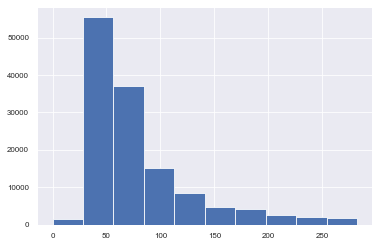

In [ ]:
icetex_predict_out['TIEMPO_PAGO_PROM'].hist()

In [ ]:
icetex_predict_out['TIEMPO_PAGO_PROM'].describe()

count    132476.000000
mean         78.800004
std          50.078036
min           0.000000
25%          46.735965
50%          60.506434
75%          91.545455
max         282.392857
Name: TIEMPO_PAGO_PROM, dtype: float64

## Movimiento por días

In [ ]:
icetex_predict_out['ESTRATO']=icetex_predict_PCA['ESTRATO'].astype(str)

<ipython-input-12-df41a52d56f3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icetex_predict_out['ESTRATO']=icetex_predict_PCA['ESTRATO'].astype(str)


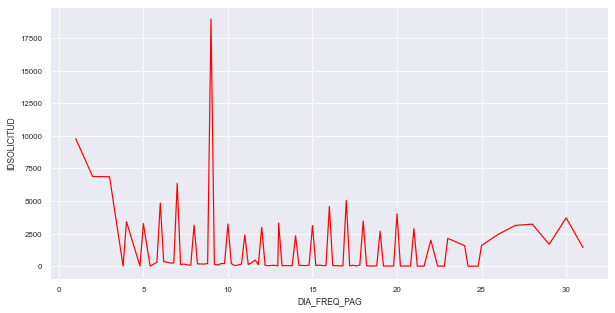

In [ ]:
icetex_predict_out1 = icetex_predict_out.groupby('DIA_FREQ_PAG').count()
icetex_predict_out1 = icetex_predict_out1.reset_index()
icetex_predict_out2 = icetex_predict_out.groupby('DIA_MOVIMIENTO').count()
icetex_predict_out2 = icetex_predict_out2.reset_index()
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x='DIA_FREQ_PAG', y='IDSOLICITUD', data=icetex_predict_out1.sort_values('DIA_FREQ_PAG'), color ='red')


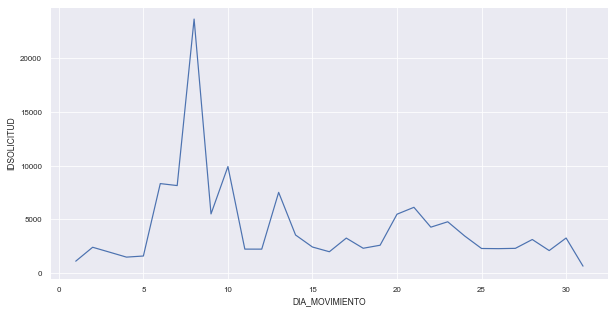

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x='DIA_MOVIMIENTO', y='IDSOLICITUD', data=icetex_predict_out2.sort_values('DIA_MOVIMIENTO'))

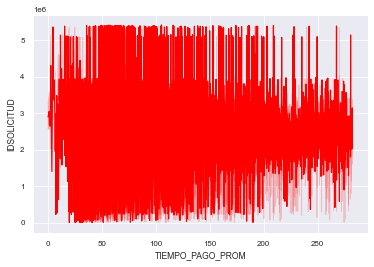

In [ ]:
sns.lineplot(x='TIEMPO_PAGO_PROM', y='IDSOLICITUD', data=icetex_predict_out.sort_values('DIA_FREQ_PAG'), color ='red')

## Tiempos de pago vs Variables Categóricas

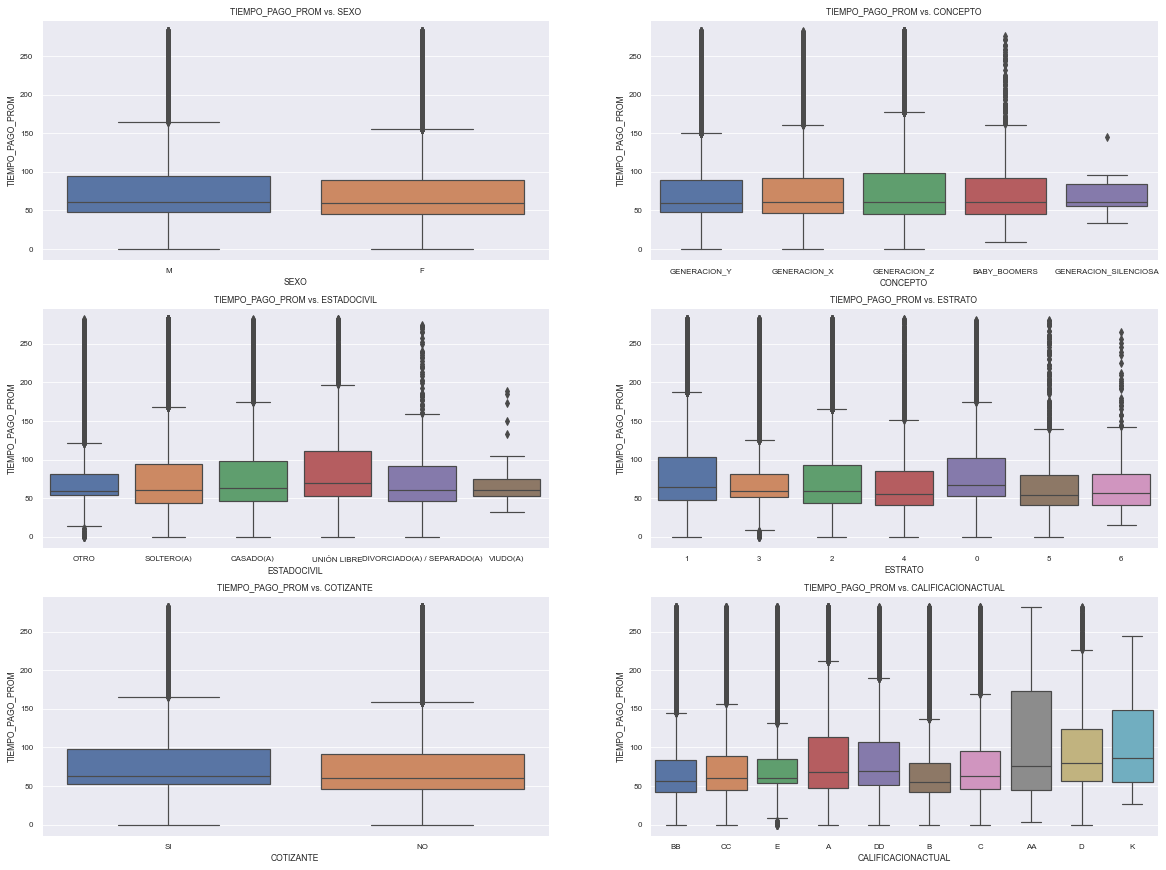

In [ ]:
plt.figure(figsize=(20,15))
vars_to_plot = ['SEXO','CONCEPTO','ESTADOCIVIL','ESTRATO','COTIZANTE','CALIFICACIONACTUAL']
for i, var in enumerate(vars_to_plot):
    plt.subplot(3,2,i+1)
    sns.boxplot(x = var, y='TIEMPO_PAGO_PROM', data = icetex_predict_out)
    title_string = "TIEMPO_PAGO_PROM vs. " + var
    plt.ylabel("TIEMPO_PAGO_PROM")
    plt.title(title_string)

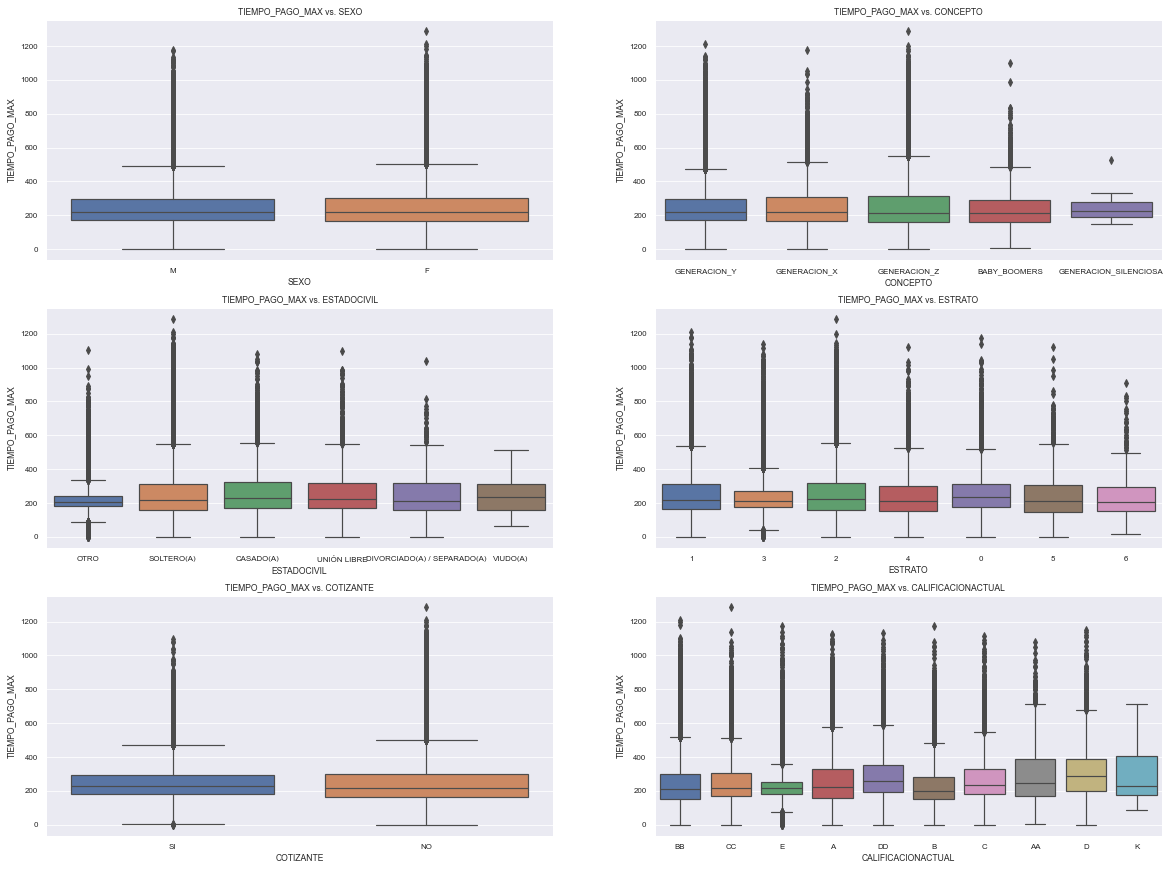

In [ ]:
plt.figure(figsize=(20,15))
vars_to_plot = ['SEXO','CONCEPTO','ESTADOCIVIL','ESTRATO','COTIZANTE','CALIFICACIONACTUAL']
for i, var in enumerate(vars_to_plot):
    plt.subplot(3,2,i+1)
    sns.boxplot(x = var, y='TIEMPO_PAGO_MAX', data = icetex_predict_out)
    title_string = "TIEMPO_PAGO_MAX vs. " + var
    plt.ylabel("TIEMPO_PAGO_MAX")
    plt.title(title_string)

## Tiempo de pago vs Variables Numéricas

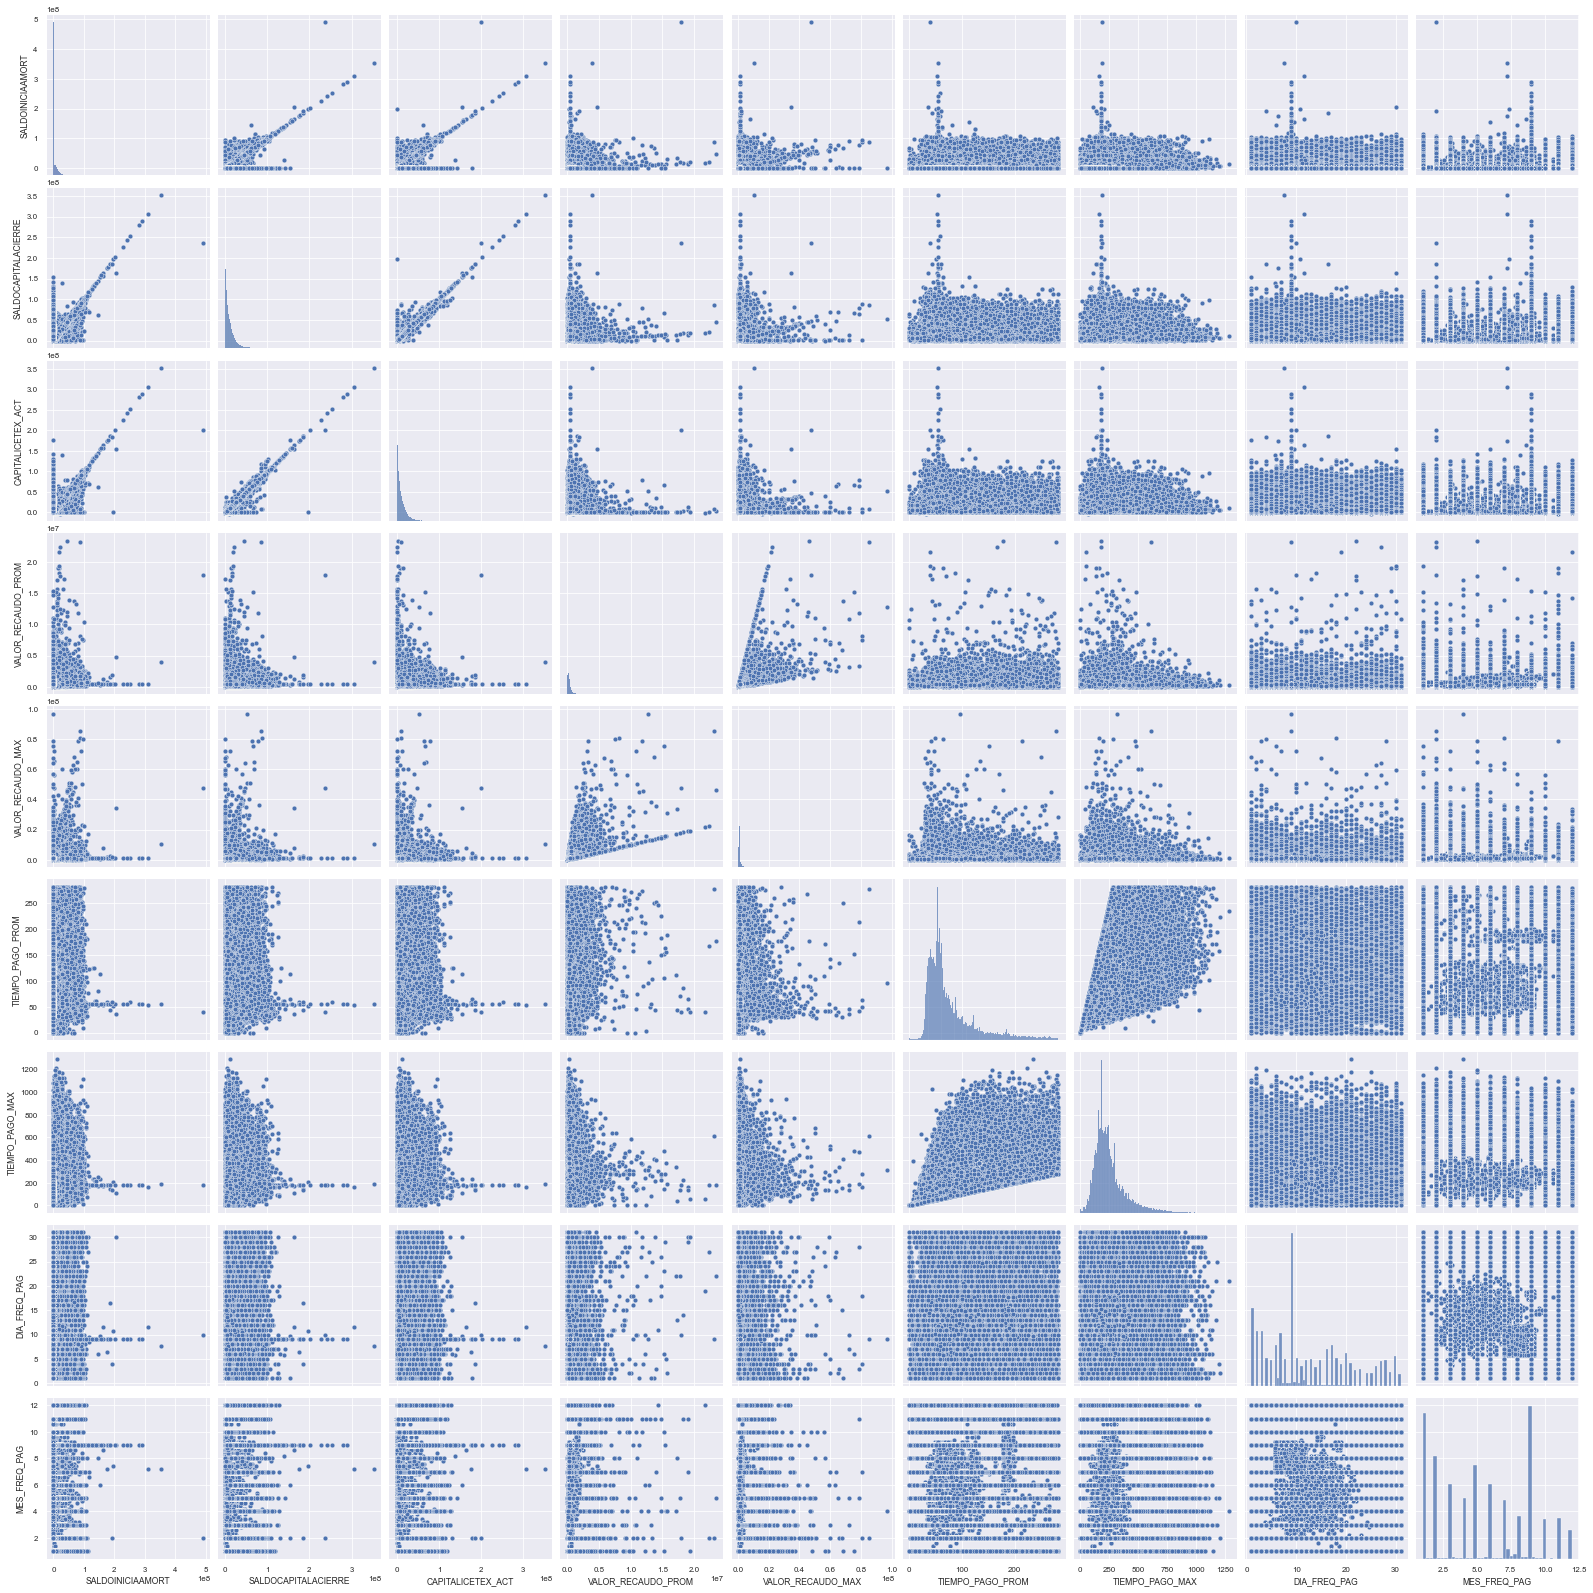

In [ ]:
icetex_socioeco = icetex_predict_out[['CALIFICACIONACTUAL','SALDOINICIAAMORT','SALDOCAPITALACIERRE',
                                     'CAPITALICETEX_ACT','VALOR_RECAUDO_PROM','VALOR_RECAUDO_MAX','TIEMPO_PAGO_PROM',
                                     'TIEMPO_PAGO_MAX','DIA_FREQ_PAG','MES_FREQ_PAG']]
sns.pairplot(icetex_socioeco)

                                  

## Correlaciones Variable Tiempo de pago

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-pack

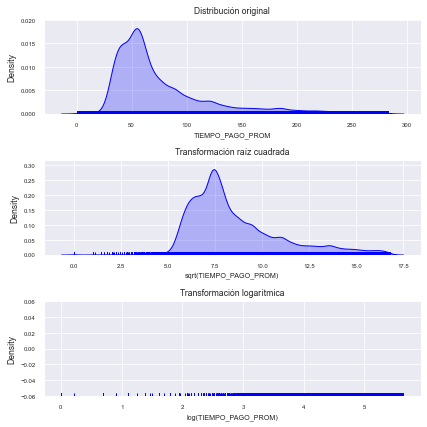

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.distplot(
    icetex_predict_out.TIEMPO_PAGO_PROM,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('TIEMPO_PAGO_PROM', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.distplot(
    np.sqrt(icetex_predict_out.TIEMPO_PAGO_PROM),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(TIEMPO_PAGO_PROM)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.distplot(
    np.log(icetex_predict_out.TIEMPO_PAGO_PROM),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(TIEMPO_PAGO_PROM)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

IndexError: ignored

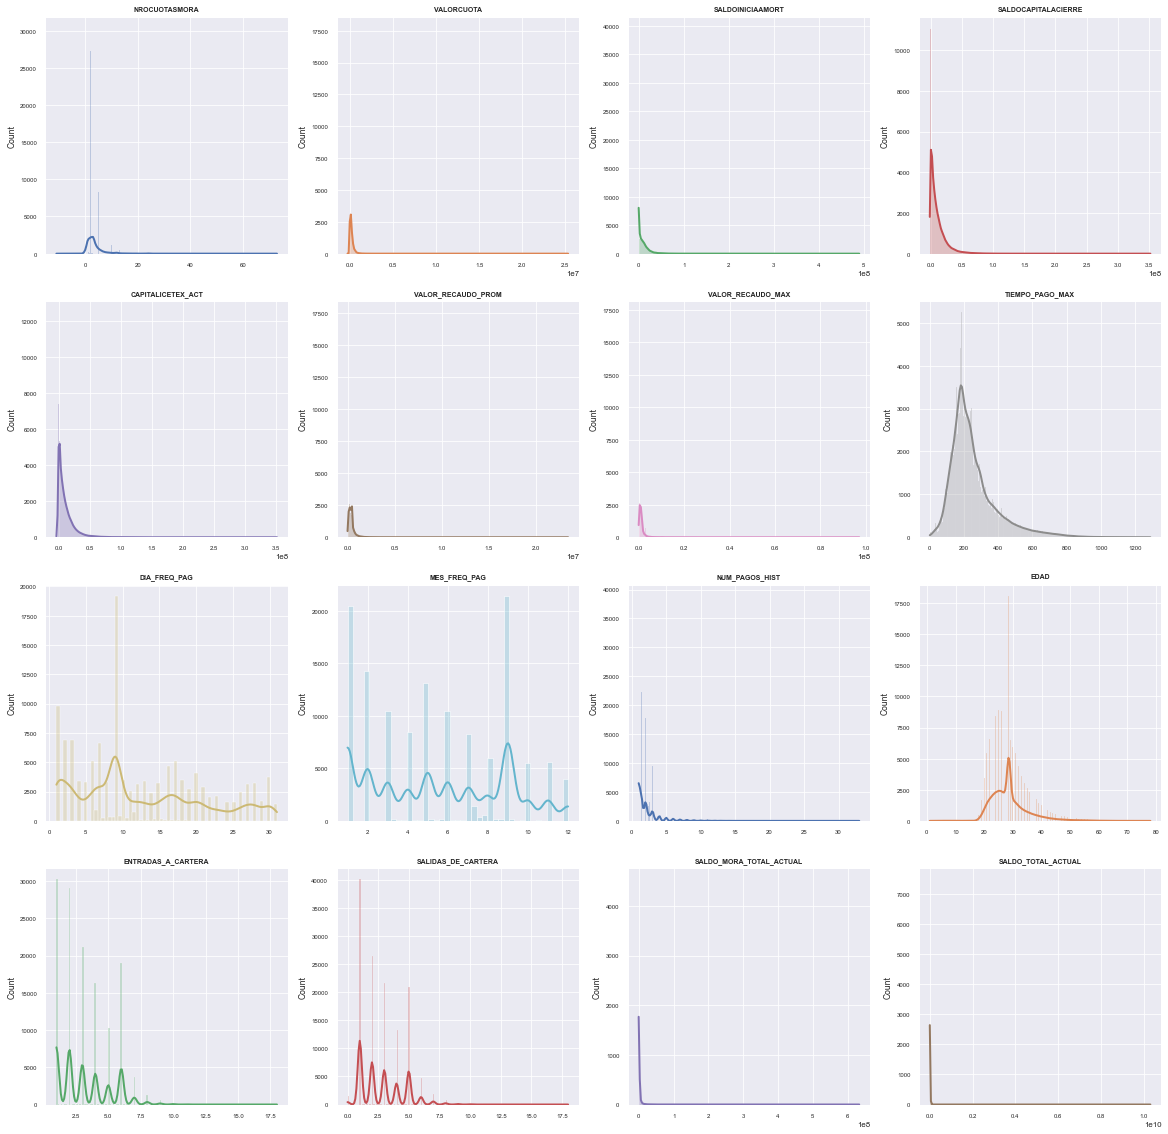

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
axes = axes.flat
columnas_numeric = icetex_predict_out.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('TIEMPO_PAGO_PROM')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = icetex_predict_out,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

IndexError: ignored

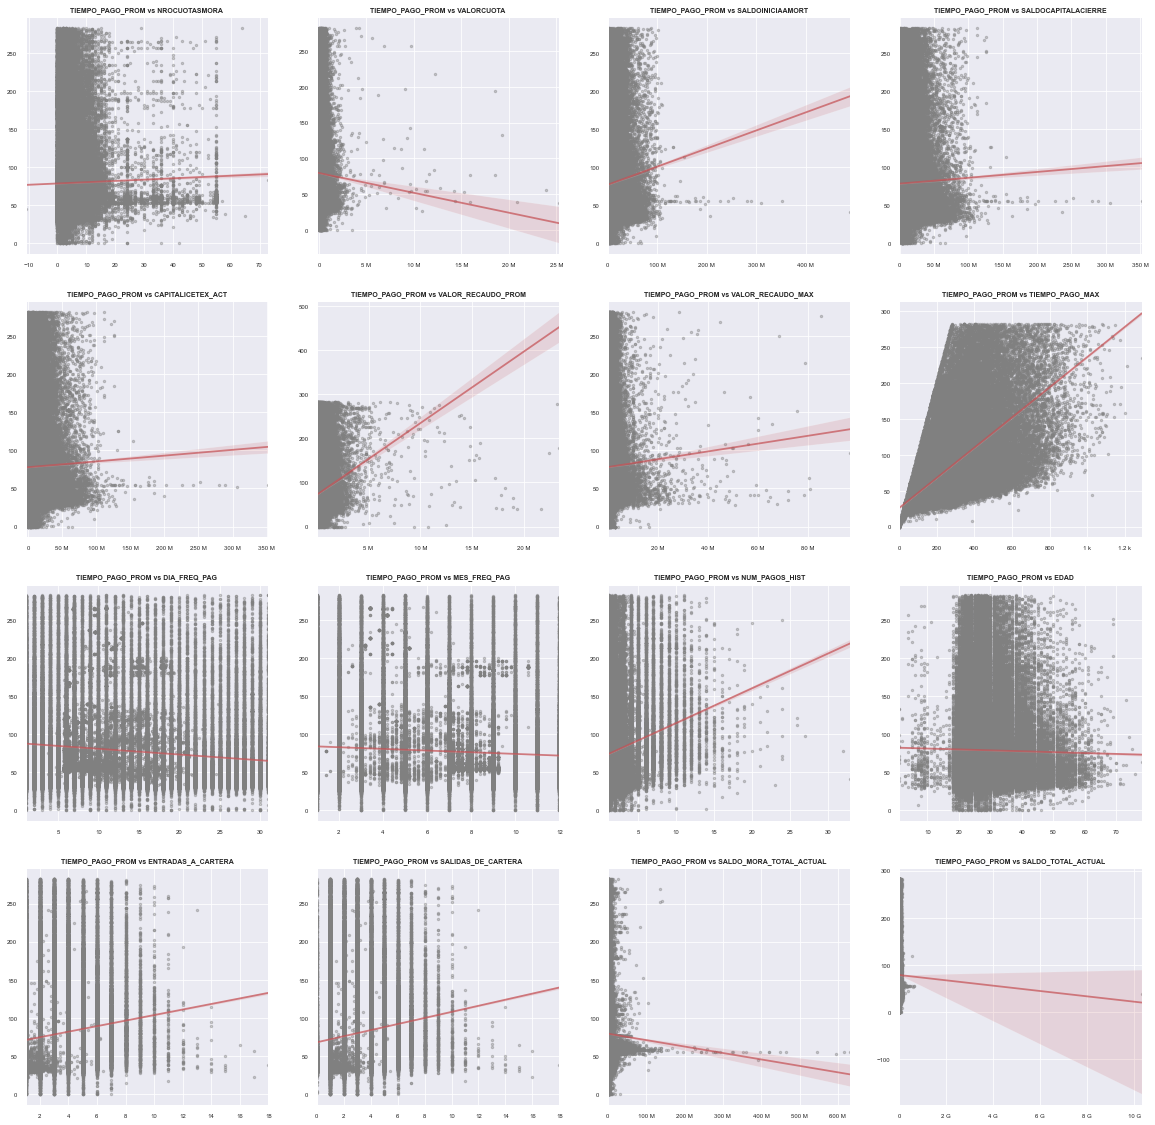

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
axes = axes.flat
columnas_numeric = icetex_predict_out.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('TIEMPO_PAGO_PROM')

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = icetex_predict_out[colum],
        y           = icetex_predict_out['TIEMPO_PAGO_PROM'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"TIEMPO_PAGO_PROM vs {colum}", fontsize = 7, fontweight = "bold")
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

for i in [8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con Tiempo Promedio de Pago', fontsize = 10, fontweight = "bold");

In [ ]:
def tidy_corr_matrix(corr_mat):

    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = icetex_predict_out.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
75,CAPITALICETEX_ACT,SALDOCAPITALACIERRE,0.985446,0.985446
58,SALDOCAPITALACIERRE,CAPITALICETEX_ACT,0.985446,0.985446
265,SALIDAS_DE_CARTERA,ENTRADAS_A_CARTERA,0.969669,0.969669
248,ENTRADAS_A_CARTERA,SALIDAS_DE_CARTERA,0.969669,0.969669
96,VALOR_RECAUDO_PROM,VALOR_RECAUDO_MAX,0.656355,0.656355
113,VALOR_RECAUDO_MAX,VALOR_RECAUDO_PROM,0.656355,0.656355
151,TIEMPO_PAGO_MAX,TIEMPO_PAGO_PROM,0.581456,0.581456
134,TIEMPO_PAGO_PROM,TIEMPO_PAGO_MAX,0.581456,0.581456
56,SALDOCAPITALACIERRE,SALDOINICIAAMORT,0.519975,0.519975
39,SALDOINICIAAMORT,SALDOCAPITALACIERRE,0.519975,0.519975


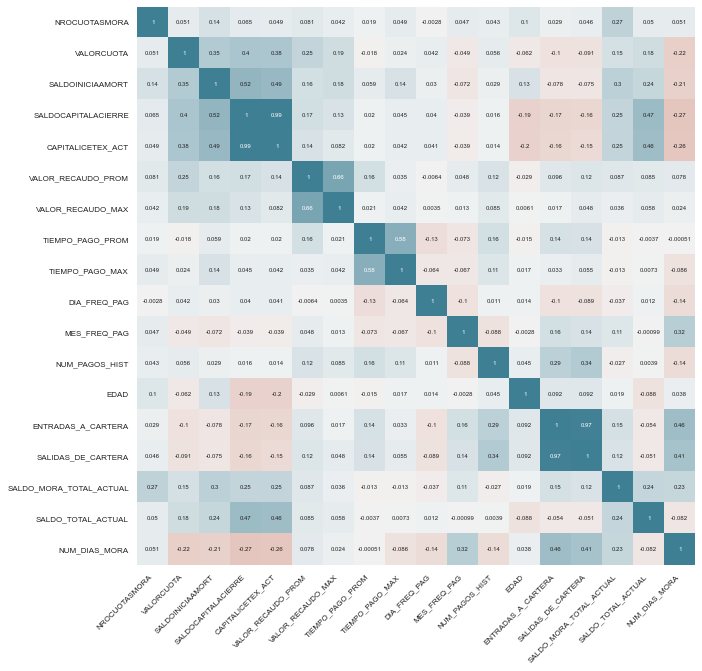

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 15))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

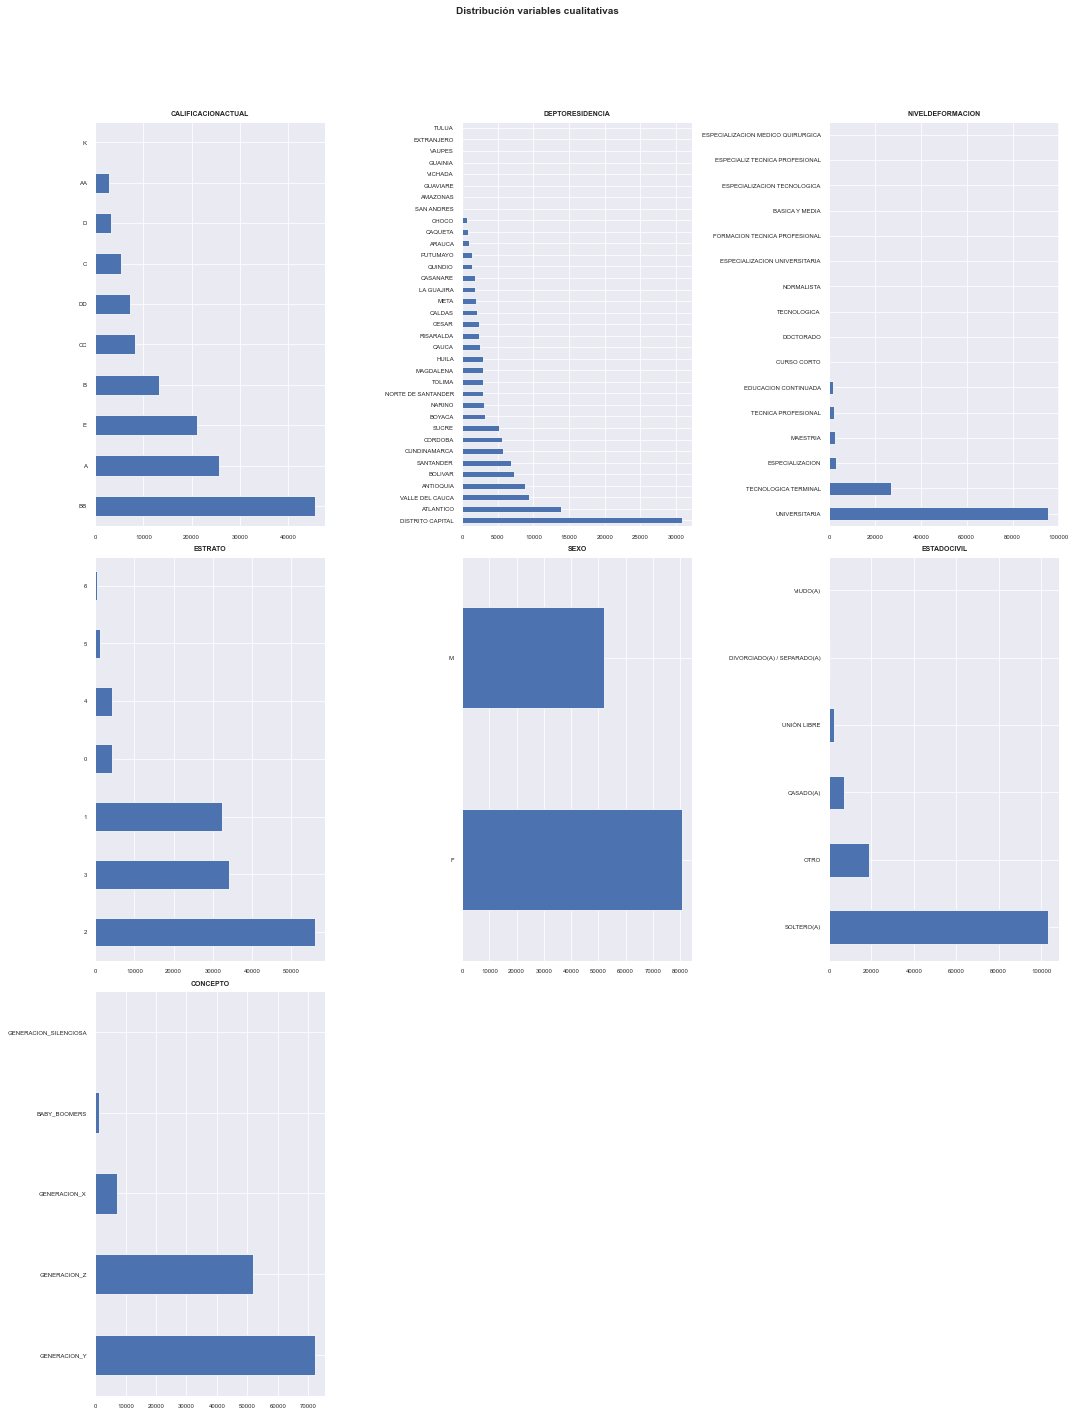

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 20))
axes = axes.flat
columnas_object = icetex_predict_out.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    icetex_predict_out[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")


for i in [7, 8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 10, fontweight = "bold");

# Análisis PCA Matriz definitiva

## Dummies Variables Categóricas 

In [ ]:
icetex_predict_out_i = icetex_predict_out.drop(columns=['IDSOLICITUD'])

In [ ]:
features = pd.DataFrame(icetex_predict_out_i.dtypes)
features.columns = ['type']
features_f = icetex_predict_out_i.select_dtypes(include=['float64', 'int']).columns
features_o = icetex_predict_out_i.select_dtypes(include=['object']).columns

In [ ]:
df_onehot = pd.get_dummies(icetex_predict_out_i, columns=features_o)
df_onehot

,NROCUOTASMORA,VALORCUOTA,SALDOINICIAAMORT,SALDOCAPITALACIERRE,CAPITALICETEX_ACT,No. ACUERDOS DE PAGO,VALOR_RECAUDO_PROM,VALOR_RECAUDO_MAX,TIEMPO_PAGO_PROM,TIEMPO_PAGO_MAX,...,ESTADOCIVIL_SOLTERO(A),ESTADOCIVIL_UNIÓN LIBRE,ESTADOCIVIL_VIUDO(A),CONCEPTO_BABY_BOOMERS,CONCEPTO_GENERACION_SILENCIOSA,CONCEPTO_GENERACION_X,CONCEPTO_GENERACION_Y,CONCEPTO_GENERACION_Z,COTIZANTE_NO,COTIZANTE_SI
0,3.0,248112.0,24689007.00,7810639.00,7810638.88,2,2.291361e+05,1000000.0,25.473684,155.0,...,0,0,0,0,0,0,1,0,0,1
1,5.0,124790.0,26125472.77,10838633.17,10644320.14,1,1.608809e+05,321000.0,40.760000,194.0,...,1,0,0,0,0,0,1,0,0,1
2,3.0,315817.0,30243848.09,9154011.67,9154011.67,5,6.182182e+05,1420271.0,90.090909,283.0,...,1,0,0,0,0,0,1,0,0,1
3,5.0,364407.0,40708635.00,13400215.00,11647451.77,6,1.237937e+06,2985994.0,85.153846,184.0,...,1,0,0,0,0,0,1,0,1,0
4,3.0,595971.0,64120343.75,45763167.32,45763167.32,8,4.658957e+05,1100423.0,43.647059,113.0,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137811,2.0,259266.0,0.00,5007000.00,5007000.00,0,4.386600e+05,1193666.2,67.419827,258.6,...,0,0,0,0,0,0,0,1,1,0
137812,3.0,274332.0,0.00,7967432.00,7967432.00,0,4.386600e+05,1193666.2,64.499827,182.2,...,1,0,0,0,0,0,0,1,1,0
137813,3.0,174200.0,0.00,3446300.00,3446300.00,0,4.386600e+05,1193666.2,56.466886,180.4,...,0,0,0,0,0,0,0,1,1,0
137814,3.0,637473.0,0.00,11712767.00,11712767.07,0,8.836930e+05,883693.0,105.176970,176.2,...,0,0,0,0,0,0,1,0,1,0


## Estandarización Variables

In [ ]:
Estandar = StandardScaler()
Estandar.fit(df_onehot)

df_std = Estandar.transform(df_onehot)
df_std = pd.DataFrame(df_std)
round(df_std.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
0,132476.0,0.0,1.0,-2.70,-0.36,-0.18,0.00,12.44
1,132476.0,-0.0,1.0,-1.39,-0.46,-0.19,0.20,75.32
2,132476.0,0.0,1.0,-0.75,-0.73,-0.31,0.34,38.37
3,132476.0,-0.0,1.0,-0.93,-0.67,-0.32,0.31,25.69
4,132476.0,0.0,1.0,-1.08,-0.68,-0.32,0.31,25.88
...,...,...,...,...,...,...,...,...
109,132476.0,0.0,1.0,-0.24,-0.24,-0.24,-0.24,4.19
110,132476.0,0.0,1.0,-1.09,-1.09,0.92,0.92,0.92
111,132476.0,0.0,1.0,-0.80,-0.80,-0.80,1.25,1.25
112,132476.0,0.0,1.0,-2.84,0.35,0.35,0.35,0.35


In [ ]:
autovalores, autovectores = np.linalg.eig(df_std.T.dot(df_std))
print(autovalores)

[ 9.73312009e+05  5.72856449e+05  4.40298833e+05  3.71348252e+05
  3.36388009e+05  2.77405859e+05  2.45521581e+05  2.33717846e+05
  2.18190976e+05  2.08238080e+05  2.00001639e+05  1.94349890e+05
  1.85321594e+05  1.76633110e+05  3.31829890e+04  3.49742613e+04
  1.65867139e+04  1.49174864e+04  4.28591634e+04  4.63834836e+04
  5.31608945e+04  1.74210522e+05  1.22875459e+04  5.72403750e+04
  6.85163541e+04  6.16860086e+04  6.17758030e+04  7.68258825e+04
  8.05804064e+04  8.22734547e+04  8.43163300e+04  8.61997118e+04
  1.63287918e+05  9.21622719e+04  9.05637800e+04  1.60280049e+05
  9.83893380e+04  1.86620937e+03  1.58488755e+03  1.56570952e+03
  1.03179392e+05  1.52868877e+05  4.40469624e+02  1.06911719e+05
  1.50534418e+05  1.49478178e+05  1.11921754e+05  1.13930867e+05
  1.15695427e+05  1.18491947e+05  1.47811484e+05  1.46717993e+05
  1.45310051e+05  1.21491110e+05  1.22612174e+05  1.43553380e+05
  1.43231698e+05  1.42358323e+05  1.24314765e+05  1.41545568e+05
  1.41019459e+05  1.40283

## Ejecución PCA 

In [ ]:
PCA = pd.DataFrame(columns = ['Variable','Autovalor'])
PCA['Variable'] = df_onehot.columns
PCA['Autovalor'] = autovalores
PCA = PCA.sort_values(by=('Autovalor'), ascending=False)
PCA.head(20)

,Variable,Autovalor
0,NROCUOTASMORA,973312.008860
1,VALORCUOTA,572856.449272
2,SALDOINICIAAMORT,440298.832644
3,SALDOCAPITALACIERRE,371348.252157
4,CAPITALICETEX_ACT,336388.009347
5,No. ACUERDOS DE PAGO,277405.858573
6,VALOR_RECAUDO_PROM,245521.580812
7,VALOR_RECAUDO_MAX,233717.846282
8,TIEMPO_PAGO_PROM,218190.976047
9,TIEMPO_PAGO_MAX,208238.079865


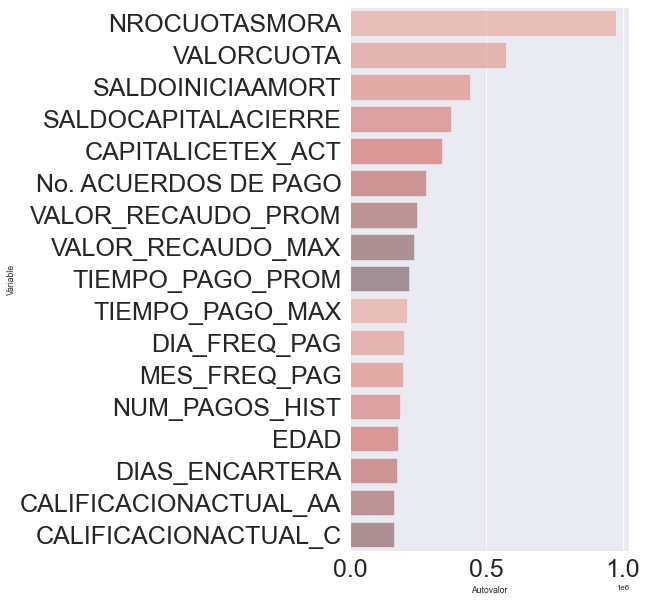

In [ ]:
PCA1 = PCA.head(17)
fig, ax = plt.subplots(figsize = (5, 10))
b=sns.barplot(data=PCA1, x='Autovalor', y='Variable', alpha=0.5,
            palette=sns.color_palette("Reds_d", n_colors=9, desat=1),
            )
b.tick_params(labelsize=25)
plt.show()

## Selección variables de estudio Modelo

In [ ]:
list(PCA['Variable'].head(60))

['NROCUOTASMORA',
 'VALORCUOTA',
 'SALDOINICIAAMORT',
 'SALDOCAPITALACIERRE',
 'CAPITALICETEX_ACT',
 'No. ACUERDOS DE PAGO',
 'VALOR_RECAUDO_PROM',
 'VALOR_RECAUDO_MAX',
 'TIEMPO_PAGO_PROM',
 'TIEMPO_PAGO_MAX',
 'DIA_FREQ_PAG',
 'MES_FREQ_PAG',
 'NUM_PAGOS_HIST',
 'EDAD',
 'DIAS_ENCARTERA',
 'CALIFICACIONACTUAL_AA',
 'CALIFICACIONACTUAL_C',
 'DEPTORESIDENCIA_AMAZONAS',
 'DEPTORESIDENCIA_ATLANTICO',
 'DEPTORESIDENCIA_BOLIVAR',
 'DEPTORESIDENCIA_CAUCA',
 'DEPTORESIDENCIA_CESAR',
 'DEPTORESIDENCIA_CHOCO',
 'DEPTORESIDENCIA_DISTRITO CAPITAL',
 'DEPTORESIDENCIA_EXTRANJERO',
 'DEPTORESIDENCIA_GUAINIA',
 'DEPTORESIDENCIA_HUILA',
 'DEPTORESIDENCIA_LA GUAJIRA',
 'DEPTORESIDENCIA_MAGDALENA',
 'DEPTORESIDENCIA_META',
 'DEPTORESIDENCIA_QUINDIO',
 'DEPTORESIDENCIA_SANTANDER',
 'DEPTORESIDENCIA_SUCRE',
 'DEPTORESIDENCIA_TOLIMA',
 'DEPTORESIDENCIA_TULUA',
 'DEPTORESIDENCIA_VAUPES',
 'DEPTORESIDENCIA_VICHADA',
 'NIVELDEFORMACION_ESPECIALIZ TECNICA PROFESIONAL',
 'NIVELDEFORMACION_EDUCACION CONTINUADA'

In [ ]:
icetex_modelo = df_onehot[['NROCUOTASMORA', 'VALORCUOTA',  'SALDOINICIAAMORT', 'SALDOCAPITALACIERRE',
                           'CAPITALICETEX_ACT','TIEMPO_PAGO_MAX', 'No. ACUERDOS DE PAGO', 'VALOR_RECAUDO_PROM', 'VALOR_RECAUDO_MAX',
                           'TIEMPO_PAGO_PROM', 'DIA_FREQ_PAG', 'MES_FREQ_PAG', 'NUM_PAGOS_HIST',
                            'SALDO_MORA_TOTAL_ACTUAL','SALDO_TOTAL_ACTUAL', 'AÑO_MOVIMIENTO','DIA_MOVIMIENTO',
                            'CALIFICACIONACTUAL_D','MES_FREQ_SALIDA','EDAD','CALIFICACIONACTUAL_AA','CALIFICACIONACTUAL_C']]

# Modelado Random Forest Regressor

## Modelo Inicial

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        icetex_modelo.drop(columns = "TIEMPO_PAGO_PROM"),
                                        icetex_modelo['TIEMPO_PAGO_PROM'],
                                        test_size=0.20
                                    )

In [ ]:
Estandar = StandardScaler()
Estandar.fit(X_train)

X_train = Estandar.transform(X_train)
X_test = Estandar.transform(X_test)

In [ ]:
modelo = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )
modelo.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=123)

In [ ]:
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 28.89336468875572


## Out of Bag Error

In [ ]:
train_scores = []
oob_scores   = []

estimator_range = range(20, 300, 70)

for n_estimators in estimator_range:
    modelo_prej = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mse',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo_prej.fit(X_train, y_train)
    train_scores.append(modelo_prej.score(X_train, y_train))
    oob_scores.append(modelo_prej.oob_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Valor óptimo de n_estimators: 230


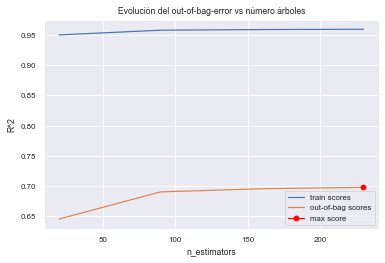

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

In [ ]:
train_scores = []
oob_scores   = []

max_features_range = range(1, X_train.shape[1] + 1, 1)
for max_features in max_features_range:
    modelo_prej = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'mse',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo_prej.fit(X_train, y_train)
    train_scores.append(modelo_prej.score(X_train, y_train))
    oob_scores.append(modelo_prej.oob_score_)

Valor óptimo de max_features: 10


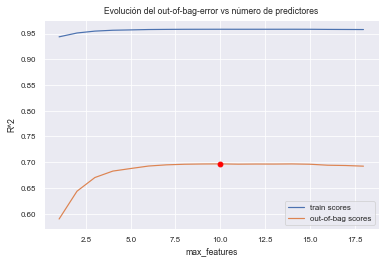

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")
sns.set(font_scale=1)


## Grid Evaluación Hiperparámetros

In [ ]:

param_grid = ParameterGrid(
                {'n_estimators': [300],
                 'max_features': [9, 7, 11],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelo_prej = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo_prej.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo_prej.oob_score_)
    print(f"modelo_prej: {params} \u2713")

resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

modelo_prej: {'max_depth': None, 'max_features': 9, 'n_estimators': 300} ✓
modelo_prej: {'max_depth': None, 'max_features': 7, 'n_estimators': 300} ✓
modelo_prej: {'max_depth': None, 'max_features': 11, 'n_estimators': 300} ✓
modelo_prej: {'max_depth': 3, 'max_features': 9, 'n_estimators': 300} ✓
modelo_prej: {'max_depth': 3, 'max_features': 7, 'n_estimators': 300} ✓
modelo_prej: {'max_depth': 3, 'max_features': 11, 'n_estimators': 300} ✓
modelo_prej: {'max_depth': 10, 'max_features': 9, 'n_estimators': 300} ✓
modelo_prej: {'max_depth': 10, 'max_features': 7, 'n_estimators': 300} ✓
modelo_prej: {'max_depth': 10, 'max_features': 11, 'n_estimators': 300} ✓
modelo_prej: {'max_depth': 20, 'max_features': 9, 'n_estimators': 300} ✓
modelo_prej: {'max_depth': 20, 'max_features': 7, 'n_estimators': 300} ✓
modelo_prej: {'max_depth': 20, 'max_features': 11, 'n_estimators': 300} ✓


,oob_r2,max_depth,max_features,n_estimators
2,0.703723,NaN,11.0,300.0
0,0.703528,NaN,9.0,300.0
1,0.701137,NaN,7.0,300.0
11,0.700268,20.0,11.0,300.0


In [ ]:
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,0], ":", resultados.iloc[0,:]['oob_r2'], "R2")

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
0.7037226280680475 : 0.7037226280680475 R2


## Grid validación cruzada evaluación Hiperparámetros

In [ ]:
param_grid = {'n_estimators': [230],
              'max_features': [9, 7, 11],
              'max_depth'   : [None, 3, 10, 20]
             }

grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
0,None,9,230,-27.402683,0.23455,-10.162938,0.030138
2,None,11,230,-27.406809,0.23305,-10.158543,0.029630
1,None,7,230,-27.495739,0.22840,-10.199160,0.030555
11,20,11,230,-27.537246,0.22614,-13.148508,0.072417


In [ ]:
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': None, 'max_features': 9, 'n_estimators': 230} : -27.402682587598655 neg_root_mean_squared_error


## Error de test de modelo final

In [ ]:
modelo_rf = grid.best_estimator_
predicciones_rf = modelo_rf.predict(X = X_test)
rmse_rf = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones_rf,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 28.89336468875572


In [ ]:
errors = abs(predicciones_rf - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = 100 * (errors/y_test)
accuracy = 100 - (mape.median())
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 16.59 degrees.
Accuracy: 85.66 %.


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


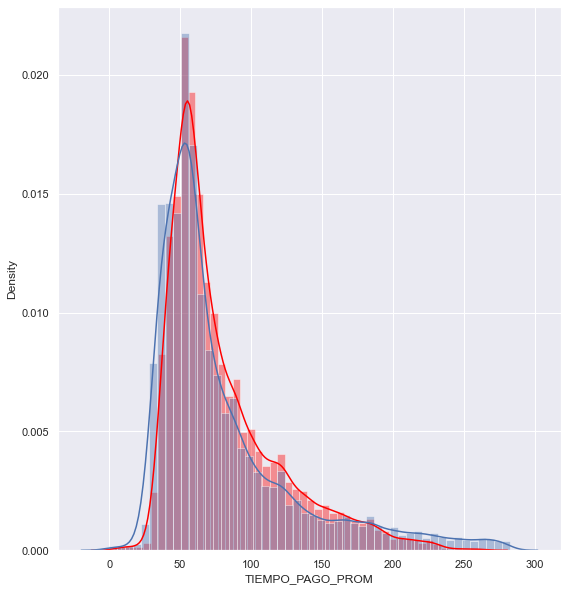

In [ ]:
fig, ax = plt.subplots(figsize=(9, 10))
sns.distplot(predicciones_rf, color ='red', label = 'Valor Predecido')
sns.distplot(y_test, label = 'Valor Actual')

In [ ]:
df_predicciones = pd.DataFrame({'Tiempo_PAGO_REAL' : y_test, 'PREDICCION_PAGO' : predicciones_rf})
df_predicciones.head()

,Tiempo_PAGO_REAL,PREDICCION_PAGO
117512,73.600000,127.583892
24007,100.444444,104.786274
74296,40.652955,55.050053
30354,58.705882,64.841251
132002,49.781771,66.041393


In [ ]:
df_predicciones.describe()

,Tiempo_PAGO_REAL,PREDICCION_PAGO
count,26496.000000,26496.000000
mean,79.565070,80.096641
std,50.336824,40.266071
min,0.000000,3.177415
25%,47.185185,52.657659
50%,60.894827,65.985609
75%,93.070833,97.296365
max,282.392857,265.031472


Text(0, 0.5, 'TIEMPO_PAGO_PROM PREDECIDO')

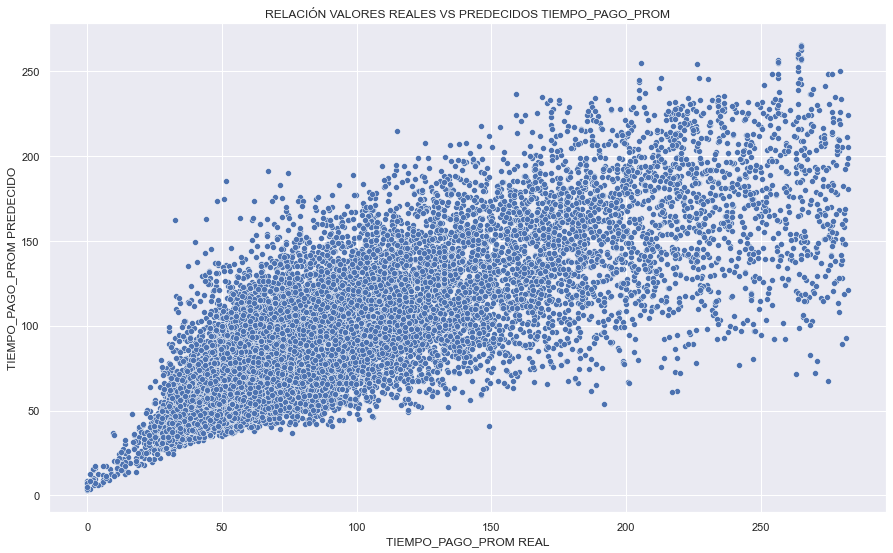

In [ ]:
fig, ax = plt.subplots(figsize = (15, 9))
sns.scatterplot(x = y_test, y= predicciones_rf, legend="full")
plt.title("RELACIÓN VALORES REALES VS PREDECIDOS TIEMPO_PAGO_PROM")
plt.xlabel("TIEMPO_PAGO_PROM REAL")
plt.ylabel("TIEMPO_PAGO_PROM PREDECIDO")

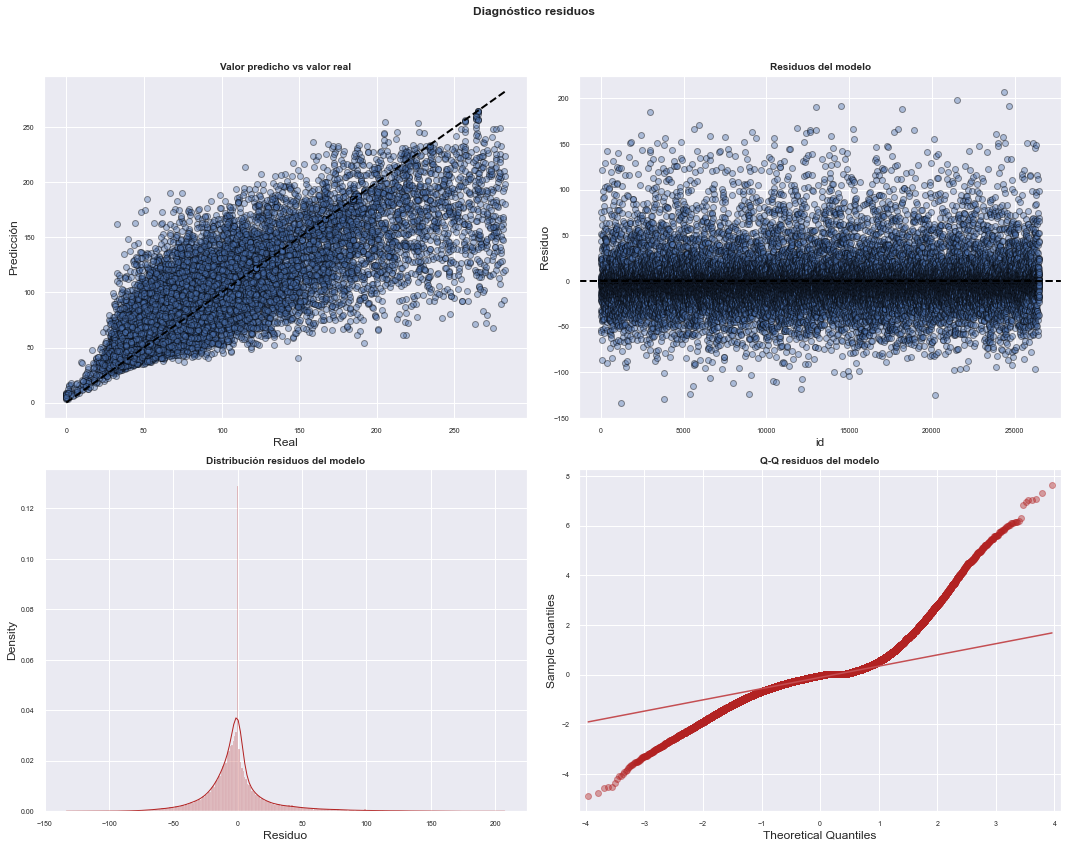

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

axes[0, 0].scatter(y_test, predicciones_rf, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_test))), y_test - predicciones_rf,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = y_test - predicciones_rf,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    y_test - predicciones_rf,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

## Importancia de predictores

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': icetex_modelo.drop(columns = "TIEMPO_PAGO_PROM").columns,
                             'importancia': modelo_rf.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
5,TIEMPO_PAGO_MAX,0.389655
7,VALOR_RECAUDO_PROM,0.118828
8,VALOR_RECAUDO_MAX,0.101461
1,VALORCUOTA,0.053843
2,SALDOINICIAAMORT,0.044457
12,SALDO_MORA_TOTAL_ACTUAL,0.039533
9,DIA_FREQ_PAG,0.034780
13,SALDO_TOTAL_ACTUAL,0.032528
3,SALDOCAPITALACIERRE,0.032377
4,CAPITALICETEX_ACT,0.030910


In [ ]:
importancia = permutation_importance(
                estimator    = modelo_rf,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )


df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = icetex_modelo.drop(columns = "TIEMPO_PAGO_PROM").columns
df_importancia.sort_values('importances_mean', ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,importances_mean,importances_std,feature
5,39.799121,0.107137,TIEMPO_PAGO_MAX
7,27.220562,0.061448,VALOR_RECAUDO_PROM
8,16.894263,0.103764,VALOR_RECAUDO_MAX
2,10.910955,0.041955,SALDOINICIAAMORT
1,10.399027,0.014092,VALORCUOTA
9,9.846639,0.028654,DIA_FREQ_PAG
6,8.941201,0.034172,No. ACUERDOS DE PAGO
13,6.359525,0.023467,SALDO_TOTAL_ACTUAL
3,5.950430,0.015768,SALDOCAPITALACIERRE
12,5.781465,0.023116,SALDO_MORA_TOTAL_ACTUAL


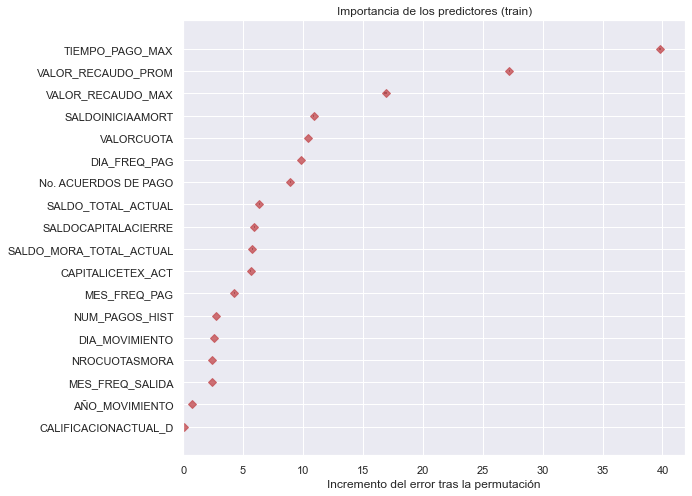

In [ ]:
fig, ax = plt.subplots(figsize=(9,8))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');